In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def simulate_PA(params):
    v,a = params
    dt = 1e-3; dB = np.sqrt(dt)
    DV = 0; t = 0
    while True:
        DV += v*dt + np.random.normal(0, dB)
        t += dt

        if DV >= a:
            return t, (v,a)
        

In [3]:
v = 1; a = 1

In [4]:
N_sim = int(1e5)

In [5]:
import numpy as np
v_distr = np.random.uniform(0.1, 3, N_sim)
a_distr = np.random.uniform(0.1, 3, N_sim)

params_np = np.array([v_distr,a_distr]).T

In [7]:
from joblib import Parallel, delayed
sim_results = Parallel(n_jobs=-1)(delayed(simulate_PA)([params_np[i,0], params_np[i,1]]) for i in range(N_sim))

In [8]:
rt_np_arr = np.array([sim_results[i][0] for i in range(N_sim)])
params_np_arr = np.array([sim_results[i][1] for i in range(N_sim)])

In [9]:
rt_np_arr.shape, params_np_arr.shape

((100000,), (100000, 2))

In [36]:
import torch
x_tensor = torch.tensor(rt_np_arr)
theta_tensor = torch.tensor(params_np_arr)

In [37]:
x_tensor.shape, theta_tensor.shape

(torch.Size([100000]), torch.Size([100000, 2]))

In [38]:
from torch.distributions import Uniform
v_distr = Uniform(torch.tensor([0.1]), torch.tensor([3]))    # decision boundary
a_distr = Uniform(torch.tensor([0.1]), torch.tensor([3]))    # decision boundary
from sbi.utils import MultipleIndependent

prior = MultipleIndependent(
    [
        v_distr,
        a_distr
    ]
)

In [39]:
from sbi.inference import SNLE
trainer = SNLE(prior = prior)


In [40]:
theta_tensor.dtype, x_tensor.dtype

(torch.float64, torch.float64)

In [42]:
theta_tensor = theta_tensor.to(dtype=torch.float32)
x_tensor = x_tensor.to(dtype=torch.float32)

print(theta_tensor.dtype, x_tensor.dtype)
print(theta_tensor.shape, x_tensor.shape)

# x_tensor = x_tensor.unsqueeze(0).squeeze(1)
print(x_tensor.shape)

torch.float32 torch.float32
torch.Size([100000, 2]) torch.Size([100000])
torch.Size([100000])


In [86]:
x_tensor = x_tensor.reshape(N_sim,1)

print(theta_tensor.shape, x_tensor.shape)
print(theta_tensor.dtype, x_tensor.dtype)
# num of dim
print(theta_tensor.dim(), x_tensor.dim())
trainer_1 = trainer.append_simulations(theta=theta_tensor,x=x_tensor).train(validation_fraction=0.2)

torch.Size([100000, 2]) torch.Size([100000, 1])
torch.float32 torch.float32
2 2
 Neural network successfully converged after 58 epochs.

In [87]:
test_sim_data = Parallel(n_jobs=-1)(delayed(simulate_PA)([v,a]) for _ in range(N_sim))


In [88]:
test_sim_rt = np.array([test_sim_data[i][0] for i in range(N_sim)])
test_sim_theta = np.array([test_sim_data[i][1] for i in range(N_sim)])

In [89]:
test_sim_rt.shape, test_sim_theta.shape

((100000,), (100000, 2))

In [90]:
test_sim_rt_tensor = torch.tensor(test_sim_rt)
test_sim_theta_tensor = torch.tensor(test_sim_theta)

In [91]:
test_sim_theta_tensor

tensor([[1, 1],
        [1, 1],
        [1, 1],
        ...,
        [1, 1],
        [1, 1],
        [1, 1]])

In [92]:
test_sim_rt_tensor.shape, test_sim_theta_tensor.shape

(torch.Size([100000]), torch.Size([100000, 2]))

In [99]:
test_data = torch.linspace(-2, 4, 1000)


In [100]:
test_data_reshape = test_data.reshape(1,1000)
test_sim_theta_tensor_reshape = test_sim_theta_tensor[:1000, :]

test_data_reshape.shape, test_sim_theta_tensor_reshape.shape

(torch.Size([1, 1000]), torch.Size([1000, 2]))

In [101]:
loglike = trainer_1.log_prob(test_data_reshape, test_sim_theta_tensor_reshape).detach()

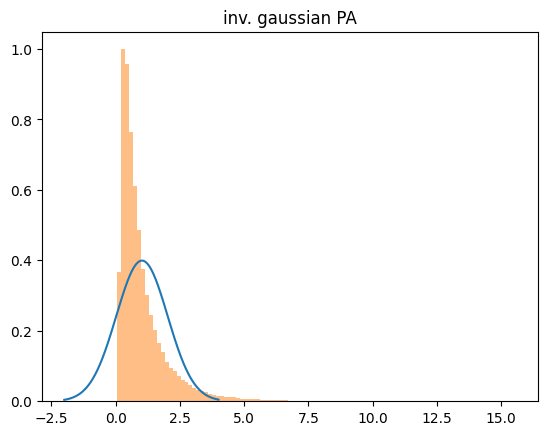

In [105]:
plt.plot(test_data, loglike.exp().squeeze());
plt.hist(test_sim_rt, bins=100, density=True, alpha=0.5);
plt.title('inv. gaussian PA');

Text(0.5, 1.0, 'Inverse gamma distr')

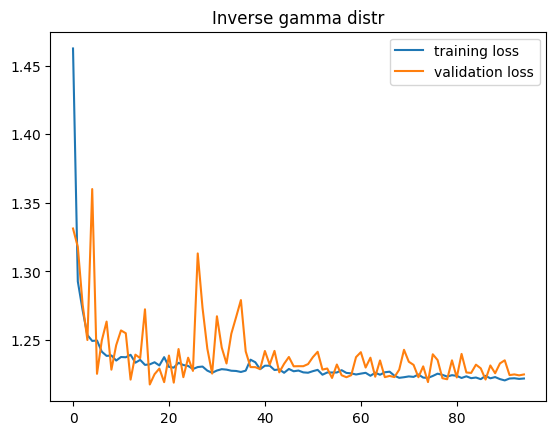

In [106]:
plt.plot(trainer._summary['training_loss'], label='training loss')
plt.plot(trainer._summary['validation_loss'], label='validation loss');
plt.legend()
plt.title('Inverse gamma distr')
